<img align="right" src="../../additional_data/banner_siegel.png" style="width:1100px;">

# Exercise on xarray

* [**Sign up to the JupyterHub**](https://www.phenocube.org/) to run this notebook interactively from your browser
* **Compatibility:** Notebook currently compatible with the Open Data Cube environments of the University of Wuerzburg

This is the exercise for using xarray library in the open data cube environment. In this exercise, you will practice how to collect Sentinel-2 data and perform basic ananlysis in Python. Our test area is in Munich.

## Set Up Environment

Let's first set up the environment on your own. You need to import all libraries that is need for running a data cube, as well as other libraries such as Pandas, Geopandas and Numpy. Connect the environment to data cube.

In [2]:
import datacube
from odc.ui import with_ui_cbk
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd

pd.set_option("display.max_colwidth", 200)
pd.set_option("display.max_rows", None)

# Connect to DataCube
# argument "app" --- user defined name for a session (e.g. choose one matching the purpose of this notebook)
dc = datacube.Datacube()

Read the shapfile calles sample_area.shp into geopandas and extract the bounding box ccordinates. Additionally you can use the pandas explore() to have a first look at the study region

In [4]:
sample_fields = gpd.read_file('data/sample_area.shp')
sample_fields.explore()

In [5]:
x = sample_fields.total_bounds[[0,2]] 
y = sample_fields.total_bounds[[1,3]]

## Load Data

Now, let's load our data. Please load data product "s2_l2a" with bands "blue", "green", "red", and "nir". 

In [8]:
data = dc.load(product= "s2_l2a",
                 measurements= ["blue", "green", "red", "nir"],
                 x= x,
                 y= y,
                 time= ("2020-06-01", "2020-08-31"),
                 group_by = "solar_day",
                 output_crs = "EPSG:32632",
                  resolution = (-10,10),
                 progress_cbk=with_ui_cbk())

data

<xarray.Dataset>
Dimensions:      (time: 36, y: 586, x: 776)
Coordinates:
  * time         (time) datetime64[ns] 2020-06-03T10:36:03 ... 2020-08-29T10:...
  * y            (y) float64 5.914e+06 5.914e+06 ... 5.909e+06 5.909e+06
  * x            (x) float64 6.626e+05 6.626e+05 ... 6.703e+05 6.703e+05
    spatial_ref  int32 32632
Data variables:
    blue         (time, y, x) uint16 178 205 212 175 218 ... 5948 6104 6452 6324
    green        (time, y, x) uint16 303 361 384 338 396 ... 4464 4504 4708 4740
    red          (time, y, x) uint16 236 253 253 246 261 ... 4256 4328 4620 5000
    nir          (time, y, x) uint16 2222 2458 2552 2388 ... 4636 4716 4948 4752
Attributes:
    crs:           EPSG:32632
    grid_mapping:  spatial_ref

## Try to check if the CRS is right

In [9]:
data.crs

'EPSG:32632'

## First Visualization

Please try to plot a histogram of the blue band across all time steps.

(array([1.15628216e+08, 2.49895390e+07, 1.49498930e+07, 2.03126080e+07,
        3.24648710e+07, 7.40204600e+06, 2.78687200e+06, 6.72486000e+05,
        8.15100000e+04, 1.45000000e+03]),
 array([    0. ,  2062.4,  4124.8,  6187.2,  8249.6, 10312. , 12374.4,
        14436.8, 16499.2, 18561.6, 20624. ]),
 <BarContainer object of 10 artists>)

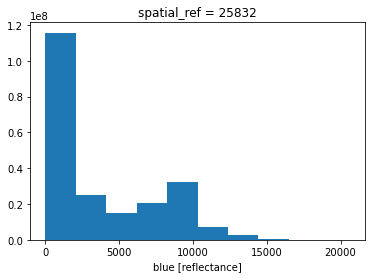

In [135]:
data.blue.plot()

Create a facetplot showing the greyscale values of the red band between 2020-07-03 - 2020-07-20

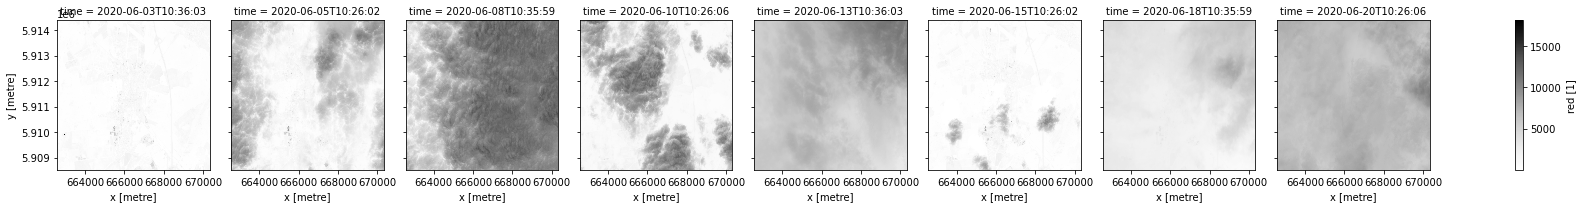

In [16]:
data.red.sel(time=slice('2020-06-03','2020-06-20')).plot(col='time', cmap='Greys')

Create the same facetplot but in RGB. Have a look at the rgb() function and try to change a few settings

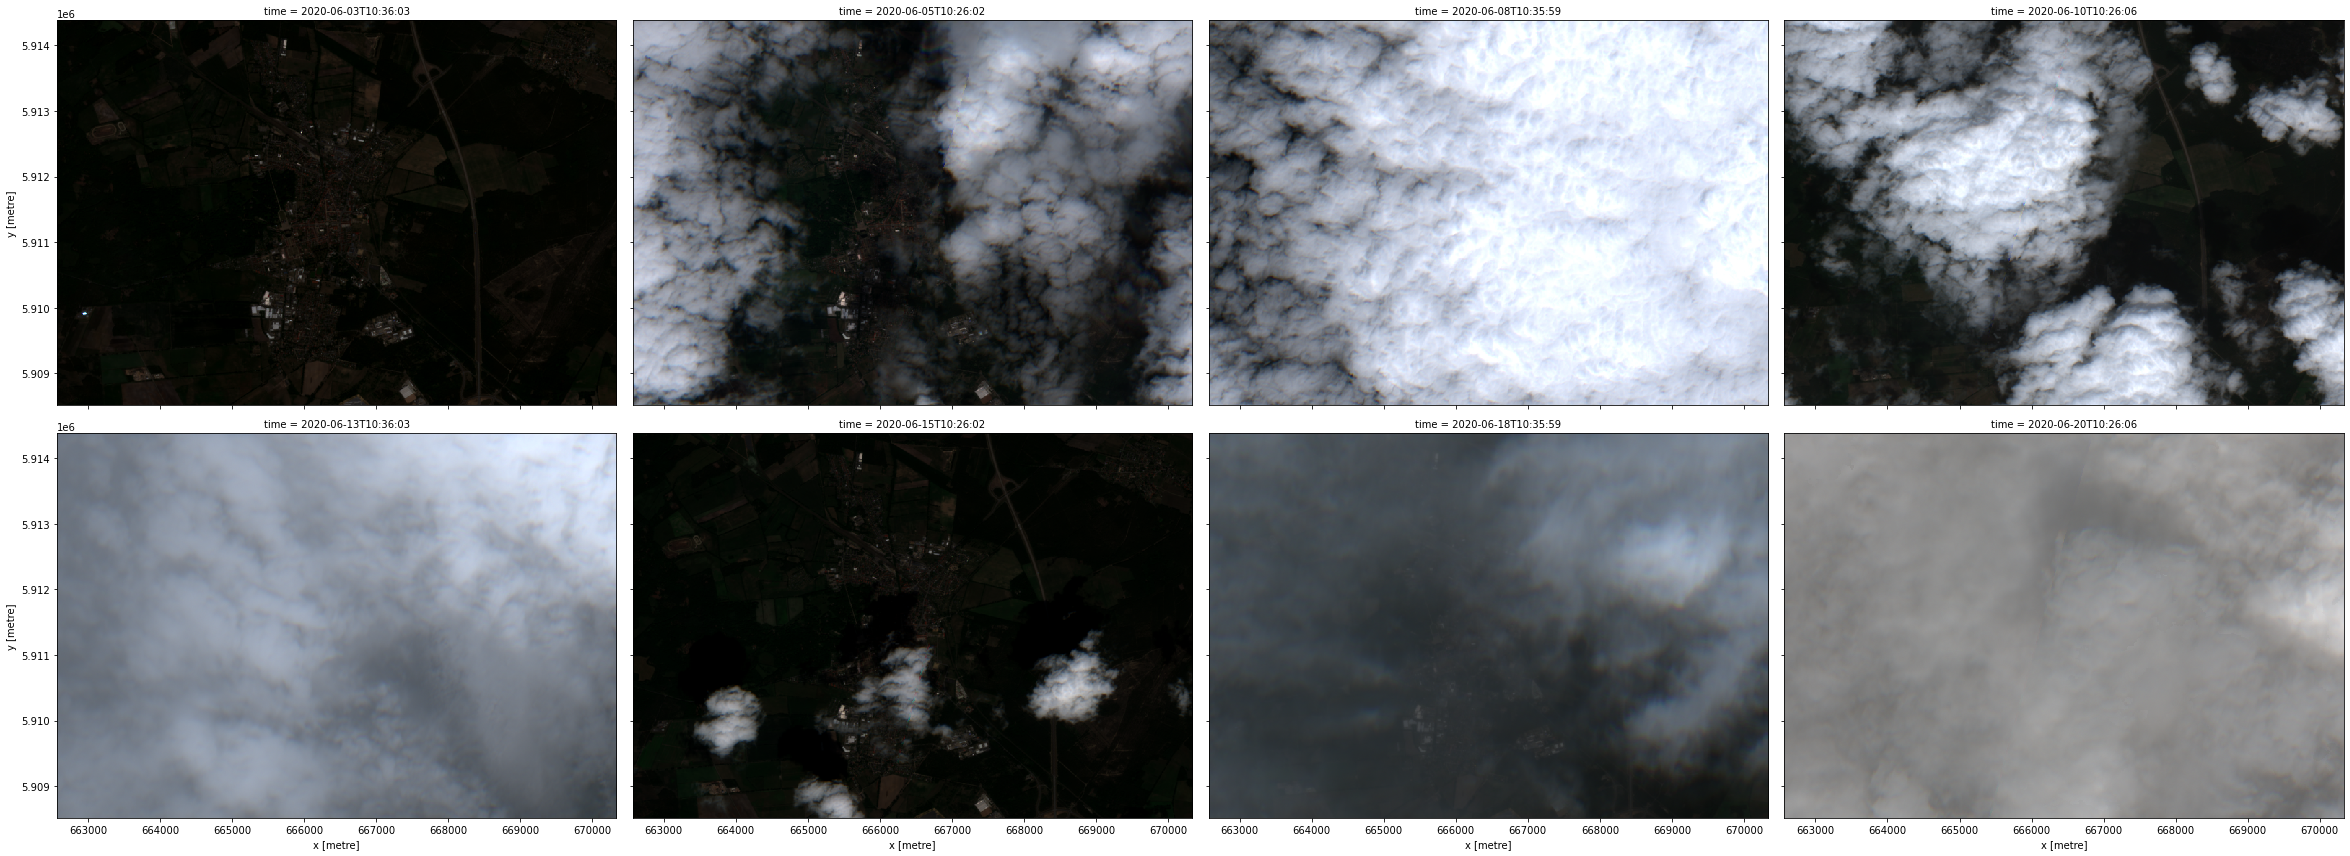

In [18]:
from deafrica_tools.plotting import rgb
data2 = data.sel(time=slice('2020-06-03','2020-06-20'))
rgb(data2, col='time', cmap='Greys')

## Statistics

Please try to compute monthly median of the blue band for the whole scene. To do so, reduce the whole scene of a single time step to a single value.

In [19]:
blue_med = data.blue.groupby("time.month").median().median(dim=["x","y"]).values

In [20]:
[round(i,2) for i in blue_med]

[5704.0, 5362.0, 797.5]

Please find out in what months are the data collected.

In [21]:
data.time.dt.month

<xarray.DataArray 'month' (time: 36)>
array([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])
Coordinates:
  * time         (time) datetime64[ns] 2020-06-03T10:36:03 ... 2020-08-29T10:...
    spatial_ref  int32 32632

And what days are they collected?

In [22]:
data.time.dt.days_in_month

<xarray.DataArray 'days_in_month' (time: 36)>
array([30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 31, 31, 31, 31, 31,
       31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31,
       31, 31])
Coordinates:
  * time         (time) datetime64[ns] 2020-06-03T10:36:03 ... 2020-08-29T10:...
    spatial_ref  int32 32632

## NDVI time series
Plese try to add a NDVI band into the dataset using the formula **NDVI = (NIR - RED)/(NIR + RED)**.

In [24]:
import odc
data =  odc.algo.to_f32(data)
data = data.assign(ndvi = (data["nir"] - data["red"])/(data["nir"] + data["red"]))

In [25]:
data

<xarray.Dataset>
Dimensions:      (time: 36, y: 586, x: 776)
Coordinates:
  * time         (time) datetime64[ns] 2020-06-03T10:36:03 ... 2020-08-29T10:...
  * y            (y) float64 5.914e+06 5.914e+06 ... 5.909e+06 5.909e+06
  * x            (x) float64 6.626e+05 6.626e+05 ... 6.703e+05 6.703e+05
    spatial_ref  int32 32632
Data variables:
    blue         (time, y, x) float32 178.0 205.0 212.0 ... 6.452e+03 6.324e+03
    green        (time, y, x) float32 303.0 361.0 384.0 ... 4.708e+03 4.74e+03
    red          (time, y, x) float32 236.0 253.0 253.0 ... 4.62e+03 5e+03
    nir          (time, y, x) float32 2.222e+03 2.458e+03 ... 4.752e+03
    ndvi         (time, y, x) float32 0.808 0.8134 0.8196 ... 0.03428 -0.02543
Attributes:
    crs:           EPSG:32632
    grid_mapping:  spatial_ref

Try to plot a time series of NDVI median for the whole scene.

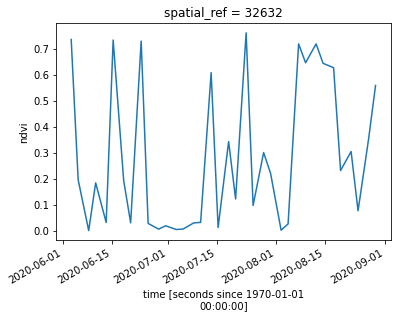

In [26]:
data.ndvi.median(dim=["x","y"]).plot()

Please plot the NDVI using imagery from **2020-06-03** as a 2D plot.

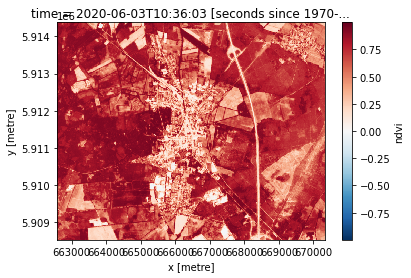

In [28]:
data.ndvi.sel(time="2020-06-03").plot()

Now, mask the pixels with NDVI higher than 0.7 only.

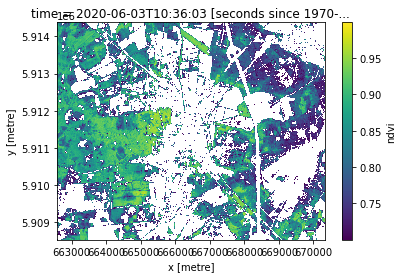

In [29]:
data.ndvi.isel(time=0).where(data.ndvi.sel(time="2020-06-03") > 0.7).plot()

Try to get the coordinates with NDVI higher than 0.7, and put x and y into two columns of a Pandas data frame.

In [30]:
green = data.ndvi.isel(time=0)

In [31]:
stacked = green.stack(pair=['x','y'])

In [32]:
stacked.pair.shape

(454736,)

In [33]:
coords = stacked.pair.values

In [34]:
green = green.values.flatten()
green.shape

(454736,)

In [35]:
coords_list = coords[green > 0.7]

In [36]:
dt = np.dtype('float,float')
np.array(coords_list, dtype = dt)

array([(662575., 5914375.), (662575., 5914365.), (662575., 5914355.), ...,
       (670325., 5908885.), (670325., 5908875.), (670325., 5908765.)],
      dtype=[('f0', '<f8'), ('f1', '<f8')])

In [37]:
coords = np.array(coords_list, dtype=dt)

In [38]:
lon = coords['f0']
lat = coords['f1']

In [39]:
df = pd.DataFrame()

df["lon"] = lon
df["lat"] = lat

df.head()

lon        lat
0  662575.0  5914375.0
1  662575.0  5914365.0
2  662575.0  5914355.0
3  662575.0  5914345.0
4  662575.0  5914335.0

Try to remap NDVI into four class:

**0: NDVI < 0.3 - Non-vegetation**

**1: 0.3 < NDVI < 0.5 - Very sparse vegetation**

**2: 0.5 < NDVI < 0.7 - Sparse vegetation**

**3: NDVI > 0.7 - Dense vegetation**

Add the class into a new variable **ndvi_class** in the xarray data frame.

In [40]:
ndvi_mat = data.ndvi.values

In [41]:
ndvi_mat.shape

(36, 586, 776)

In [42]:
remap = np.zeros_like(ndvi_mat)

remap[ndvi_mat < 0.3] = 0
remap[(ndvi_mat > 0.3) & (ndvi_mat < 0.5)] = 1
remap[(ndvi_mat > 0.5) & (ndvi_mat < 0.7)] = 2
remap[(ndvi_mat > 0.7)] = 3

remap

array([[[3., 3., 3., ..., 0., 0., 0.],
        [3., 3., 3., ..., 0., 0., 0.],
        [3., 3., 3., ..., 0., 0., 0.],
        ...,
        [2., 2., 2., ..., 1., 1., 1.],
        [2., 3., 2., ..., 1., 1., 1.],
        [2., 3., 3., ..., 1., 1., 1.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [43]:
remap.shape

(36, 586, 776)

In [44]:
data

<xarray.Dataset>
Dimensions:      (time: 36, y: 586, x: 776)
Coordinates:
  * time         (time) datetime64[ns] 2020-06-03T10:36:03 ... 2020-08-29T10:...
  * y            (y) float64 5.914e+06 5.914e+06 ... 5.909e+06 5.909e+06
  * x            (x) float64 6.626e+05 6.626e+05 ... 6.703e+05 6.703e+05
    spatial_ref  int32 32632
Data variables:
    blue         (time, y, x) float32 178.0 205.0 212.0 ... 6.452e+03 6.324e+03
    green        (time, y, x) float32 303.0 361.0 384.0 ... 4.708e+03 4.74e+03
    red          (time, y, x) float32 236.0 253.0 253.0 ... 4.62e+03 5e+03
    nir          (time, y, x) float32 2.222e+03 2.458e+03 ... 4.752e+03
    ndvi         (time, y, x) float32 0.808 0.8134 0.8196 ... 0.03428 -0.02543
Attributes:
    crs:           EPSG:32632
    grid_mapping:  spatial_ref

In [45]:
data["ndvi_class"] = (['time', 'y', 'x'], remap)

Visualize this newly created NDVI class using the first time step.

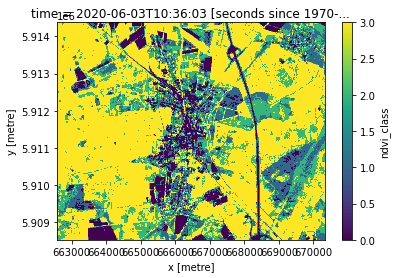

In [46]:
data.isel(time=[0]).ndvi_class.plot()

## Unsupervised Classification
 
Now use the single scene from **2020-06-03**. Please try to use the RGB bands of the scene to cluster the pixels into 5 different groups. Plot the result afterwards.

The required libraries are imported for you.

In [47]:
from sklearn.cluster import KMeans
import numpy as np

In [48]:
import rasterio as rio
from rasterio.plot import show
from sklearn import cluster
import matplotlib.pyplot as plt
import numpy as np

In [51]:
r = data.red.sel(time="2020-06-03").values.flatten()
g = data.green.sel(time="2020-06-03").values.flatten()
b = data.blue.sel(time="2020-06-03").values.flatten()

arr = np.stack((r,g,b), axis=-1)

In [55]:
cl = cluster.KMeans(n_clusters=5) # create an object of the classifier
param = cl.fit(arr) # train it
img_cl = cl.labels_ # get the labels of the classes
img_cl = img_cl.reshape(data.red.sel(time="2020-06-03").values.shape) # reshape labels to a 3d array (one band only)

In [56]:
img_cl

array([[[0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        ...,
        [3, 3, 3, ..., 1, 1, 1],
        [3, 3, 3, ..., 1, 1, 1],
        [3, 3, 3, ..., 1, 1, 1]]], dtype=int32)

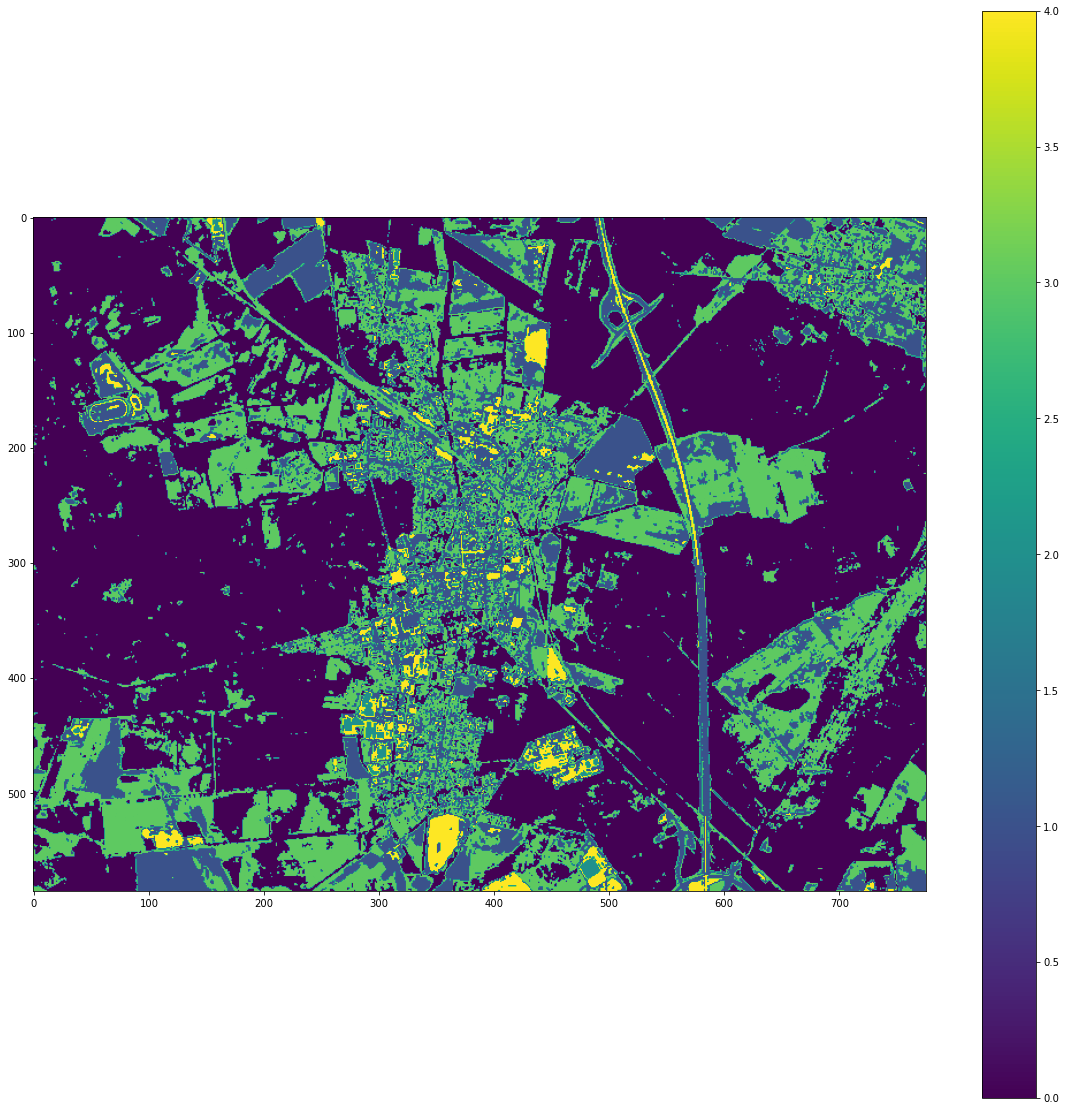

In [57]:
plt.figure(figsize=(20,20))
plt.imshow(img_cl[0])
plt.colorbar()